<a href="https://www.kaggle.com/code/youneseloiarm/mitsui-co-flaml-with-lags-sub-02?scriptVersionId=260643967" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

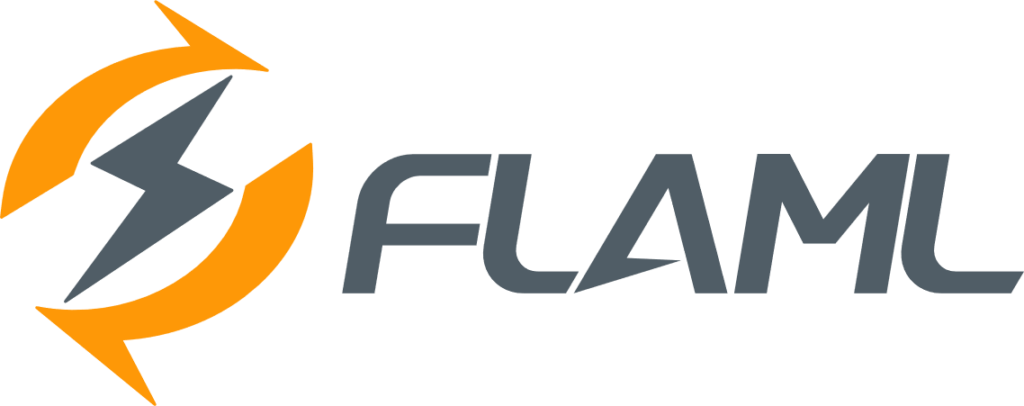

---

**In this notebook, we will use FLAML AutoML for a multi-target regression problem, leveraging lagged targets to predict 424 outputs. To speed up inference, we adopt the long-format multi-output prediction method, which is much faster than the standard multi-output approach.**

**You will also find several useful techniques in this notebook, including:**

* How to create lagged targets and use them in the prediction step
* How to run AutoML models offline (without internet access)
* How to build an optimized prediction function for API inference



---

In [1]:
!pip install --no-index --no-deps /kaggle/input/flaml-124/wheelhouse/FLAML-2.3.5-py3-none-any.whl
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Processing /kaggle/input/flaml-124/wheelhouse/FLAML-2.3.5-py3-none-any.whl


In [2]:
from flaml import AutoML
import kaggle_evaluation.mitsui_inference_server
from sklearn import *
import numpy as np
import pandas as pd
import polars as pl
import os, warnings
warnings.filterwarnings("ignore")

p = '/kaggle/input/mitsui-commodity-prediction-challenge/'
train = pd.read_csv(p+'train.csv')
trainl = pd.read_csv(p+'train_labels.csv')
traint = pd.read_csv(p+'target_pairs.csv')

In [3]:
trainl = trainl.fillna(0)

In [4]:
target_lag_1 = traint.loc[traint["lag"]==1,"target"].values
target_lag_2 = traint.loc[traint["lag"]==2,"target"].values
target_lag_3 = traint.loc[traint["lag"]==3,"target"].values
target_lag_4 = traint.loc[traint["lag"]==4,"target"].values

In [5]:
Features = [i for i in trainl.columns[1:] ]
def creat_lagged_labels(df):
    dt = pd.DataFrame()
    dt["date_id"] = df["date_id"]
    for f in Features:
        if f in target_lag_1:
            lag = 1
        elif f in target_lag_2:
            lag = 2
        elif f in target_lag_3:
            lag = 3
        elif f in target_lag_4:
            lag = 4    
        dt[f] = df[f].shift(lag).fillna(0)
    return df, dt

In [6]:
_,train_lagged = creat_lagged_labels(trainl)

In [7]:
train_lagged2 = train_lagged[-600:].copy()
trainl2 = trainl[-600:].copy()

In [8]:
# long-format multi-output predictions method:
import gc
training_df = []
target_cols = [f"target_{i}" for i in range(424)]
for j, target_col in enumerate(target_cols):
    temp_train_df = pd.DataFrame()
    temp_train_df[Features]  = train_lagged2[Features]                     
    #temp_train_df = X_trains2.copy()
    temp_train_df['target_id'] = j
    y = trainl2[target_col].values
    temp_train_df['target'] = y
    mask = ~(np.isnan(y) | np.isinf(y) | (np.abs(y) > 1e10))
    training_df.append(temp_train_df[mask].copy())
    del temp_train_df,y
    gc.collect()
training_df = pd.concat(training_df).reset_index(drop=True)

In [9]:
# Memory optimization
def reduce_memory_usage(df):
    """Optimize DataFrame memory usage by downcasting numeric columns."""
    start_mem = df.memory_usage().sum() / 1024**3
    print(f"Starting memory: {start_mem:.2f} GB")
    
    for col in df.select_dtypes(include=['float']).columns:
        col_min = df[col].min()
        col_max = df[col].max()
        
        if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
            df[col] = df[col].astype(np.float16)
        elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
            df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage().sum() / 1024**3
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f"Memory reduced to: {end_mem:.2f} GB ({reduction:.1f}% reduction)")
    return df
training_df = reduce_memory_usage(training_df)

Starting memory: 0.81 GB
Memory reduced to: 0.20 GB (74.8% reduction)


In [10]:
training_df.to_csv("training_df.csv",index=False)

In [11]:
import dill
label = "target"  # replace with your target column name
train_x = training_df.drop(columns=[label])
train_y = training_df[label]

# Load AutoML object
with open("/kaggle/input/mitsui-co-flaml-with-lags-02/flaml_model.dill", "rb") as f:
    automl = dill.load(f)

In [12]:
# Predict
preds = automl.predict(train_x)
preds

array([-0.00234209,  0.00014946,  0.00010038, ...,  0.00285706,
        0.00394347,  0.01509392])

In [13]:
X_data = train_x.copy()
X_data["preds"] = preds

In [14]:
X_data[["target_id","preds"]]

,target_id,preds
0,0,-0.002342
1,0,0.000149
2,0,0.000100
3,0,-0.000171
4,0,0.000845
...,...,...
254395,423,-0.019157
254396,423,-0.004290
254397,423,0.002857
254398,423,0.003943


In [15]:
# Step 1: Add row ID for test samples (0 to 89 repeated 424 times)
df_preds = X_data.copy()
df_preds['row'] = df_preds.groupby('target_id').cumcount()

# Step 2: Pivot the table to wide format
df_wide = df_preds.pivot(index='row', columns='target_id', values='preds')

# Step 3: Optionally, sort columns by target_id
df_wide = df_wide.sort_index(axis=1)
df_wide.index = [i for i in df_wide.index]
# Step 4: Rename columns (optional)
df_wide.columns = [f'target_{i}' for i in df_wide.columns]
df_wide
# Done: df_wide has shape (90, 424)

,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,-0.002342,0.000238,0.007110,0.001260,-0.024832,-0.026386,-0.001164,-0.012774,-0.015172,-0.003807,...,0.009094,0.001278,0.005311,0.014374,0.002183,0.001251,0.004044,0.006103,0.026440,0.004150
1,0.000149,-0.002735,0.002842,0.003362,0.004319,0.006414,-0.002662,-0.001003,0.004215,0.002734,...,0.008382,-0.001631,0.006925,-0.003671,0.003125,0.003016,-0.002660,0.012412,0.003755,0.000511
2,0.000100,-0.000290,0.000268,0.000478,-0.000178,-0.000446,-0.000589,-0.000120,-0.000560,-0.000399,...,0.017406,-0.010668,0.004681,0.007587,-0.001082,0.002138,0.005429,0.007452,0.017818,0.010454
3,-0.000171,-0.000218,0.000446,0.000193,-0.000068,-0.000053,0.000176,-0.000105,-0.000312,-0.000296,...,0.000152,0.001151,0.004774,0.019624,0.003666,0.000763,-0.000175,0.002410,0.019307,0.002926
4,0.000845,-0.000123,0.000005,0.000103,-0.000204,-0.000179,0.000041,-0.000604,-0.000367,-0.000183,...,0.016484,0.002908,0.002428,0.016063,0.002053,-0.000330,0.001443,0.005207,0.029127,0.002950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,-0.000928,-0.002742,-0.000185,0.002698,-0.002066,-0.006774,-0.006865,-0.002982,-0.001398,0.001337,...,0.000948,0.001019,0.000503,0.000043,-0.000174,-0.001148,0.001528,-0.001019,-0.000658,-0.019157
596,-0.000420,-0.000203,-0.001122,0.000149,-0.003663,-0.004686,-0.002138,-0.002377,-0.002715,-0.000848,...,0.004851,-0.003492,0.003582,0.004886,-0.003068,-0.000553,0.001801,-0.003530,0.000760,-0.004290
597,0.000319,-0.000605,-0.000232,-0.000361,0.000452,-0.000002,0.000850,0.001424,0.001878,0.000881,...,-0.002562,-0.000799,0.000830,-0.002494,-0.000276,0.000295,0.005697,-0.005142,0.002085,0.002857
598,0.001318,-0.001711,-0.000431,-0.000660,-0.004051,-0.002036,-0.000114,0.000856,-0.001349,0.000974,...,0.004812,0.002046,-0.004955,0.000707,-0.004577,-0.001969,0.002747,0.001951,0.005024,0.003943


In [16]:
#https://www.kaggle.com/code/metric/mitsui-co-commodity-prediction-metric
def rank_correlation_sharpe_ratio(merged_df: pd.DataFrame) -> float:
    prediction_cols = [col for col in merged_df.columns if col.startswith('prediction_')]
    target_cols = [col for col in merged_df.columns if col.startswith('target_')]
    def _compute_rank_correlation(row):
        non_null_targets = [col for col in target_cols if not pd.isnull(row[col])]
        matching_predictions = [col for col in prediction_cols if col.replace('prediction', 'target') in non_null_targets]
        if not non_null_targets:
            raise ValueError('No non-null target values found')
        if row[non_null_targets].std(ddof=0) == 0 or row[matching_predictions].std(ddof=0) == 0:
            raise ZeroDivisionError('Denominator is zero, unable to compute rank correlation.')
        return np.corrcoef(row[matching_predictions].rank(method='average'), row[non_null_targets].rank(method='average'))[0, 1]
    daily_rank_corrs = merged_df.apply(_compute_rank_correlation, axis=1)
    std_dev = daily_rank_corrs.std(ddof=0)
    if std_dev == 0:
        raise ZeroDivisionError('Denominator is zero, unable to compute Sharpe ratio.')
    sharpe_ratio = daily_rank_corrs.mean() / std_dev
    return float(sharpe_ratio)

def score(solution: pd.DataFrame, submission: pd.DataFrame) -> float:
    assert all(solution.columns == submission.columns)
    submission = submission.rename(columns={col: col.replace('target_', 'prediction_') for col in submission.columns})
    solution = solution.replace(0, None)
    return rank_correlation_sharpe_ratio(pd.concat([solution, submission], axis='columns'))

In [17]:
trainl2[Features[1:]]

,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
1361,0.001821,0.018480,-0.000787,-0.028932,-0.043041,0.012657,-0.020624,-0.021405,-0.007235,0.025614,...,0.010973,0.000000,0.000000,0.022754,0.000000,0.000000,0.004530,0.000000,0.036240,0.000000
1362,-0.010400,0.005819,0.003771,0.005047,0.010893,-0.007133,-0.003677,0.009363,0.006784,-0.014830,...,0.011409,-0.008656,0.016508,-0.009595,0.003681,0.002923,-0.008764,0.019141,0.006281,-0.000503
1363,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.025929,-0.020087,0.009405,0.009683,-0.005347,0.004830,0.005506,0.006320,0.021067,0.009988
1364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.034523,0.000000,0.000000,0.000000,0.000000,0.023841,0.000000
1365,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002109,0.000000,0.001445,...,0.029758,0.000000,0.000000,0.019700,0.000000,0.000000,0.001110,0.000000,0.038361,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956,-0.004500,-0.001530,-0.003022,0.000000,0.000000,-0.006263,0.001251,0.000000,0.002182,0.000000,...,0.000000,0.010110,0.009248,0.000000,0.009526,0.004318,0.000000,0.005344,0.000000,-0.041391
1957,-0.001036,0.000409,-0.003524,-0.008052,-0.013435,0.013214,-0.008121,0.005308,-0.006430,0.016660,...,-0.006012,-0.007567,0.021569,0.008000,0.015748,-0.001036,0.001043,0.015982,0.004550,-0.028627
1958,-0.002032,0.001083,0.004975,0.016810,0.020511,-0.003176,-0.002232,0.012985,0.007888,-0.025815,...,-0.026047,-0.007783,0.005746,-0.020410,0.026720,0.007130,0.004826,-0.002617,-0.033630,-0.007604
1959,-0.006335,-0.003885,0.002704,-0.004042,-0.001637,0.000142,-0.010872,-0.002934,0.004181,-0.006940,...,-0.006359,-0.006478,0.012228,0.013633,0.022029,0.000092,0.016932,-0.000136,-0.006557,0.009290


In [18]:
df_wide[Features[1:]]

,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,0.000238,0.007110,0.001260,-0.024832,-0.026386,-0.001164,-0.012774,-0.015172,-0.003807,0.011176,...,0.009094,0.001278,0.005311,0.014374,0.002183,0.001251,0.004044,0.006103,0.026440,0.004150
1,-0.002735,0.002842,0.003362,0.004319,0.006414,-0.002662,-0.001003,0.004215,0.002734,-0.006495,...,0.008382,-0.001631,0.006925,-0.003671,0.003125,0.003016,-0.002660,0.012412,0.003755,0.000511
2,-0.000290,0.000268,0.000478,-0.000178,-0.000446,-0.000589,-0.000120,-0.000560,-0.000399,-0.000570,...,0.017406,-0.010668,0.004681,0.007587,-0.001082,0.002138,0.005429,0.007452,0.017818,0.010454
3,-0.000218,0.000446,0.000193,-0.000068,-0.000053,0.000176,-0.000105,-0.000312,-0.000296,-0.000057,...,0.000152,0.001151,0.004774,0.019624,0.003666,0.000763,-0.000175,0.002410,0.019307,0.002926
4,-0.000123,0.000005,0.000103,-0.000204,-0.000179,0.000041,-0.000604,-0.000367,-0.000183,0.000808,...,0.016484,0.002908,0.002428,0.016063,0.002053,-0.000330,0.001443,0.005207,0.029127,0.002950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,-0.002742,-0.000185,0.002698,-0.002066,-0.006774,-0.006865,-0.002982,-0.001398,0.001337,0.002840,...,0.000948,0.001019,0.000503,0.000043,-0.000174,-0.001148,0.001528,-0.001019,-0.000658,-0.019157
596,-0.000203,-0.001122,0.000149,-0.003663,-0.004686,-0.002138,-0.002377,-0.002715,-0.000848,0.004588,...,0.004851,-0.003492,0.003582,0.004886,-0.003068,-0.000553,0.001801,-0.003530,0.000760,-0.004290
597,-0.000605,-0.000232,-0.000361,0.000452,-0.000002,0.000850,0.001424,0.001878,0.000881,0.001463,...,-0.002562,-0.000799,0.000830,-0.002494,-0.000276,0.000295,0.005697,-0.005142,0.002085,0.002857
598,-0.001711,-0.000431,-0.000660,-0.004051,-0.002036,-0.000114,0.000856,-0.001349,0.000974,0.002658,...,0.004812,0.002046,-0.004955,0.000707,-0.004577,-0.001969,0.002747,0.001951,0.005024,0.003943


In [19]:
df_wide.index = trainl2.index

In [20]:
trainl2[Features[1:]]

,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
1361,0.001821,0.018480,-0.000787,-0.028932,-0.043041,0.012657,-0.020624,-0.021405,-0.007235,0.025614,...,0.010973,0.000000,0.000000,0.022754,0.000000,0.000000,0.004530,0.000000,0.036240,0.000000
1362,-0.010400,0.005819,0.003771,0.005047,0.010893,-0.007133,-0.003677,0.009363,0.006784,-0.014830,...,0.011409,-0.008656,0.016508,-0.009595,0.003681,0.002923,-0.008764,0.019141,0.006281,-0.000503
1363,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.025929,-0.020087,0.009405,0.009683,-0.005347,0.004830,0.005506,0.006320,0.021067,0.009988
1364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.034523,0.000000,0.000000,0.000000,0.000000,0.023841,0.000000
1365,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002109,0.000000,0.001445,...,0.029758,0.000000,0.000000,0.019700,0.000000,0.000000,0.001110,0.000000,0.038361,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956,-0.004500,-0.001530,-0.003022,0.000000,0.000000,-0.006263,0.001251,0.000000,0.002182,0.000000,...,0.000000,0.010110,0.009248,0.000000,0.009526,0.004318,0.000000,0.005344,0.000000,-0.041391
1957,-0.001036,0.000409,-0.003524,-0.008052,-0.013435,0.013214,-0.008121,0.005308,-0.006430,0.016660,...,-0.006012,-0.007567,0.021569,0.008000,0.015748,-0.001036,0.001043,0.015982,0.004550,-0.028627
1958,-0.002032,0.001083,0.004975,0.016810,0.020511,-0.003176,-0.002232,0.012985,0.007888,-0.025815,...,-0.026047,-0.007783,0.005746,-0.020410,0.026720,0.007130,0.004826,-0.002617,-0.033630,-0.007604
1959,-0.006335,-0.003885,0.002704,-0.004042,-0.001637,0.000142,-0.010872,-0.002934,0.004181,-0.006940,...,-0.006359,-0.006478,0.012228,0.013633,0.022029,0.000092,0.016932,-0.000136,-0.006557,0.009290


In [21]:
df_wide[Features[1:]]

,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
1361,0.000238,0.007110,0.001260,-0.024832,-0.026386,-0.001164,-0.012774,-0.015172,-0.003807,0.011176,...,0.009094,0.001278,0.005311,0.014374,0.002183,0.001251,0.004044,0.006103,0.026440,0.004150
1362,-0.002735,0.002842,0.003362,0.004319,0.006414,-0.002662,-0.001003,0.004215,0.002734,-0.006495,...,0.008382,-0.001631,0.006925,-0.003671,0.003125,0.003016,-0.002660,0.012412,0.003755,0.000511
1363,-0.000290,0.000268,0.000478,-0.000178,-0.000446,-0.000589,-0.000120,-0.000560,-0.000399,-0.000570,...,0.017406,-0.010668,0.004681,0.007587,-0.001082,0.002138,0.005429,0.007452,0.017818,0.010454
1364,-0.000218,0.000446,0.000193,-0.000068,-0.000053,0.000176,-0.000105,-0.000312,-0.000296,-0.000057,...,0.000152,0.001151,0.004774,0.019624,0.003666,0.000763,-0.000175,0.002410,0.019307,0.002926
1365,-0.000123,0.000005,0.000103,-0.000204,-0.000179,0.000041,-0.000604,-0.000367,-0.000183,0.000808,...,0.016484,0.002908,0.002428,0.016063,0.002053,-0.000330,0.001443,0.005207,0.029127,0.002950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956,-0.002742,-0.000185,0.002698,-0.002066,-0.006774,-0.006865,-0.002982,-0.001398,0.001337,0.002840,...,0.000948,0.001019,0.000503,0.000043,-0.000174,-0.001148,0.001528,-0.001019,-0.000658,-0.019157
1957,-0.000203,-0.001122,0.000149,-0.003663,-0.004686,-0.002138,-0.002377,-0.002715,-0.000848,0.004588,...,0.004851,-0.003492,0.003582,0.004886,-0.003068,-0.000553,0.001801,-0.003530,0.000760,-0.004290
1958,-0.000605,-0.000232,-0.000361,0.000452,-0.000002,0.000850,0.001424,0.001878,0.000881,0.001463,...,-0.002562,-0.000799,0.000830,-0.002494,-0.000276,0.000295,0.005697,-0.005142,0.002085,0.002857
1959,-0.001711,-0.000431,-0.000660,-0.004051,-0.002036,-0.000114,0.000856,-0.001349,0.000974,0.002658,...,0.004812,0.002046,-0.004955,0.000707,-0.004577,-0.001969,0.002747,0.001951,0.005024,0.003943


In [22]:
score(trainl2[Features[1:]],df_wide[Features[1:]])

3.5361691665325474

In [23]:
ycols = ['target_' + str(i) for i in range(424)]
Features2 = [i for i in training_df.columns if i!="target"]

In [24]:
##automl
def predict(
    test: pl.DataFrame,
    lag1: pl.DataFrame, 
    lag2: pl.DataFrame,
    lag3: pl.DataFrame,
    lag4: pl.DataFrame,
) -> pl.DataFrame:
    """
    Predicts target values using lag features.
    Handles empty input and replaces null values with 0.
    Optimized for performance by:
    - Minimizing data conversions
    - Using vectorized operations
    - Reducing memory allocations
    - Parallelizing predictions where possible
    """
    # Combine lag features in one operation
    X_pred = pl.concat(
        [   test.select(["date_id"]),
            lag1.select(target_lag_1),
            lag2.select(target_lag_2),
            lag3.select(target_lag_3),
            lag4.select(target_lag_4),
        ],
        how="horizontal"
    )
    # If no rows, return all zeros
    if X_pred.height == 0:
        return pl.DataFrame(0, schema=[(f"target_{i}", pl.Float64) for i in range(424)])
    
    # Fill nulls with 0
    X_pred = X_pred.fill_null(0)
    # Prepare features for prediction in one go
    # Create all target_id combinations without materializing full DataFrame
    n_targets = 424
    n_rows = X_pred.height
    #print(X_pred[Features])
    # Prepare features for all targets at once
    features_array = np.tile(X_pred[Features].to_numpy(), (n_targets, 1))
    target_ids = np.repeat(np.arange(n_targets), n_rows)
    #print(Features)
    # Create final prediction DataFrame efficiently
    X_pred2 = pl.DataFrame({
       "date_id": np.tile(X_pred["date_id"].to_numpy(), n_targets),
       **{feat: features_array[:, i] for i, feat in enumerate(Features)},
       "target_id": target_ids,
       "row": np.tile(np.arange(n_rows), 424)
    })
    #print(X_pred2)
    # Predict in batches for memory efficiency
    #batch_size = 10000
    preds = np.zeros(len(X_pred2))
    #print(X_pred2[Features2])
    test_data = X_pred2[Features2].to_pandas()
    #print(test_data)
    predictions = automl.predict(test_data)
    #h2o_predictions_df = h2o_predictions.as_data_frame()
    #h2o_predictions_df.values
    X_pred2 = X_pred2.with_columns(pl.Series("preds", predictions))
    # Pivot to wide format more efficiently
    df_wide = (
        X_pred2.lazy()
        .group_by(["target_id", "row"])
        .agg(pl.col("preds").first())
        .collect()
        .pivot(index="row", columns="target_id", values="preds")
        .sort("row")
    )

    # Ensure correct column order by sorting by target_id
    col_order = sorted([col for col in df_wide.columns if col != "row"], key=int)
    df_wide = df_wide.select(["row"] + col_order)

    # Rename columns to target_0 ... target_423
    df_wide.columns = ["row"] + [f"target_{i}" for i in range(424)]
    # Get column names in order
    target_cols = [f"target_{i}" for i in range(424)]
    df_wide = df_wide.select(target_cols)
    #print(df_wide)
    # Return last row as predictions
    return df_wide.tail(1).to_pandas()

In [25]:
# submission through the API
import kaggle_evaluation.mitsui_inference_server
inference_server = kaggle_evaluation.mitsui_inference_server.MitsuiInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/mitsui-commodity-prediction-challenge/',))

In [26]:
display(pl.read_parquet('/kaggle/working/submission.parquet'))

date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,target_30,target_31,target_32,target_33,target_34,target_35,…,target_387,target_388,target_389,target_390,target_391,target_392,target_393,target_394,target_395,target_396,target_397,target_398,target_399,target_400,target_401,target_402,target_403,target_404,target_405,target_406,target_407,target_408,target_409,target_410,target_411,target_412,target_413,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1827,-0.000034,-0.001406,-0.000134,-0.001057,-0.000451,-0.000867,0.001358,-0.001664,-0.000983,0.001236,0.000275,0.000619,0.000744,-0.003019,0.000833,0.002456,0.002592,-0.001227,-0.000568,0.001298,-0.00258,-0.00352,-0.001981,0.000943,0.001314,-0.001507,-0.000287,0.001187,0.001475,0.000906,-0.001434,-0.001036,-0.000438,0.000659,-0.000864,-0.001649,…,-0.002514,-0.00599,0.001941,0.001745,-0.001211,0.000134,0.00006,0.000635,0.001573,-0.001802,0.002848,-0.001277,-0.002432,0.000198,-0.005074,-0.002083,0.000375,0.00129,0.005739,0.003106,-0.000995,-0.006413,-0.003057,0.005851,-0.004162,-0.000618,-0.003627,0.000942,0.002714,0.000689,0.004069,0.01198,0.009047,0.000572,0.0047,0.00749,0.000068
1828,-0.000034,-0.001406,-0.000134,-0.001057,-0.000451,-0.000867,0.001358,-0.001664,-0.000983,0.001236,0.000275,0.000619,0.000744,-0.003019,0.000833,0.002456,0.002592,-0.001227,-0.000568,0.001298,-0.00258,-0.00352,-0.001981,0.000943,0.001314,-0.001507,-0.000287,0.001187,0.001475,0.000906,-0.001434,-0.001036,-0.000438,0.000659,-0.000864,-0.001649,…,-0.002514,-0.00599,0.001941,0.001745,-0.001211,0.000134,0.00006,0.000635,0.001573,-0.001802,0.002848,-0.001277,-0.002432,0.000198,-0.005074,-0.002083,0.000375,0.00129,0.005739,0.003106,-0.000995,-0.006413,-0.003057,0.005851,-0.004162,-0.000618,-0.003627,0.000942,0.002714,0.000689,0.004069,0.01198,0.009047,0.000572,0.0047,0.00749,0.000068
1829,-0.000265,-0.001749,-0.001193,-0.00217,-0.001311,0.000661,0.001781,-0.000787,-0.000919,-0.000199,0.00066,0.000998,0.001053,-0.000696,0.001175,0.003157,0.002845,-0.001407,-0.001123,0.00066,-0.002859,-0.002595,-0.001479,0.001412,0.00027,-0.001755,0.000392,0.002097,0.002406,0.001796,-0.000758,-0.001055,-0.000596,0.001187,-0.000248,-0.000848,…,-0.000865,-0.006669,0.002499,0.001122,-0.002259,0.001259,-0.001749,0.002137,0.002409,-0.004231,0.000462,-0.001693,-0.003277,0.000365,-0.004442,0.000498,-0.00098,0.000391,0.005632,0.004286,0.004214,-0.004896,-0.000096,0.008546,-0.002737,0.00072,-0.000669,0.001133,0.00146,-0.003147,-0.003551,0.010573,0.008638,0.00025,0.004698,0.004383,-0.002119
1830,0.002097,-0.007902,0.003846,0.002095,-0.00088,0.000619,-0.002394,-0.00566,0.001784,0.002583,-0.00374,-0.002753,-0.004624,-0.007041,-0.004197,0.000924,0.001555,0.000951,-0.000754,-0.000555,-0.001918,-0.003113,0.006234,-0.00045,0.005035,-0.003665,-0.002079,0.003823,0.004163,0.00149,-0.006785,-0.003309,-0.006351,-0.003797,0.001643,0.000728,…,0.001121,-0.005757,0.004312,0.002023,-0.001911,0.003393,-0.011955,0.000748,0.005603,0.003115,-0.003316,-0.001783,-0.001677,0.00134,-0.000961,0.008912,0.001543,-0.00353,0.003676,0.005651,0.004412,-0.00366,-0.000461,0.006026,0.002979,0.010981,0.003119,0.001163,0.000471,-0.005725,-0.010185,0.012431,0.00644,-0.004838,0.0021,-0.00044,0.007902
1831,0.000504,-0.00124,0.003425,0.003273,-0.00005,-0.002997,-0.000407,-0.002017,0.000612,-0.000353,0.001488,0.002582,0.004601,-0.0001,0.003143,0.002261,0.001859,-0.003208,-0.001